<a href="https://colab.research.google.com/github/kavyajeetbora/ETL_wages/blob/master/WIOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation and Import

```python
world_industry_values.to_excel('filename.xlsx')
```

In [2]:
%%time
# !wget https://dataverse.nl/api/access/datafile/199104 -O wiot.zip
!wget -q https://dataverse.nl/api/access/datafile/199097 -O exchange_rates.xlsx
!wget -q https://dataverse.nl/api/access/datafile/199095 -O sea.xlsx
!wget -q https://dataverse.nl/api/access/datafile/354108 -O NA_data.xlsx
!wget -q https://raw.githubusercontent.com/kavyajeetbora/ETL_wages/master/data/PPP_export.csv -O ppp.csv

CPU times: user 34.1 ms, sys: 6.2 ms, total: 40.3 ms
Wall time: 3.17 s


In [3]:
import pandas as pd
from zipfile import ZipFile
from tqdm import tqdm
import seaborn as sns
# from pyxlsb import open_workbook as open_xlsb

## SEA

In [4]:
%%time
sea = pd.read_excel("sea.xlsx", sheet_name='DATA')

CPU times: user 14.3 s, sys: 288 ms, total: 14.6 s
Wall time: 25.4 s


In [5]:
sea.head(3)

,country,variable,description,code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,AUS,CAP,"Crop and animal production, hunting and relate...",A01,9739.77,13729.03,9726.30,11808.62,11163.98,12429.90,8706.66,11227.29,12556.71,13768.79,18441.27,20106.04,19659.28,18986.06,20525.22
1,AUS,CAP,Forestry and logging,A02,582.69,740.04,540.79,651.96,649.34,676.64,549.27,616.70,716.86,749.91,894.94,923.40,1001.44,1247.96,1206.44
2,AUS,CAP,Fishing and aquaculture,A03,869.31,1122.29,652.69,1024.72,1059.83,923.46,904.15,863.98,1146.37,1108.94,1116.14,1213.94,1182.11,1388.98,1475.22


In [6]:
year_range = list(range(2000,2015))

## Convert to USD $

In [7]:
exchange = pd.read_excel('exchange_rates.xlsx', sheet_name='EXR', header=3)
exchange.columns = list(exchange.columns[:2].str.lower()) + [int(c.replace("_", "")) for c in exchange.columns[2:]]
exchange.loc[exchange['acronym']=='ROM', 'acronym'] = 'ROU'
exchange = pd.melt(exchange, id_vars=['acronym'], value_vars=list(range(2000,2015)), var_name='Year')
exchange.head(3)

,acronym,Year,value
0,AUS,2000,0.582346
1,AUT,2000,0.923600
2,BEL,2000,0.923600


In [8]:
SEA = pd.melt(sea, id_vars=['country','variable','code'], value_vars= year_range, var_name='year')
SEA.head(3)

,country,variable,code,year,value
0,AUS,CAP,A01,2000,9739.77
1,AUS,CAP,A02,2000,582.69
2,AUS,CAP,A03,2000,869.31


In [9]:
SEA_USD = pd.merge(left=SEA,
         right=exchange,
         how='left',
         left_on=SEA['country']+SEA['year'].astype(str),
         right_on=exchange['acronym']+exchange['Year'].astype(str),
         suffixes=('', '_y')
)

SEA_USD['value'] = SEA_USD['value']*SEA_USD['value_y']
SEA_USD = SEA_USD.drop(['key_0', 'value_y', 'acronym', 'Year'], axis=1)

## Unpivot changes
SEA_USD = SEA_USD.pivot(columns=['year'], index=['country','variable', 'code'], values='value').reset_index()
SEA_USD.head(3)

year,country,variable,code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,AUS,CAP,A01,5671.916100,7106.640173,5290.163749,7697.850440,8223.153224,9494.504536,6559.162311,9414.767530,10739.314578,10895.298602,16956.729324,20753.655548,20363.082224,18386.613128,18528.013468
1,AUS,CAP,A02,339.327191,383.071345,294.137303,425.002293,478.290208,516.847404,413.792554,517.140569,613.105268,593.406783,822.896435,953.142714,1037.291552,1208.558159,1089.047356
2,AUS,CAP,A03,506.239201,580.937706,355.000049,667.998572,780.648522,705.379380,681.141402,724.499933,980.450138,877.508658,1026.289614,1253.041007,1224.429538,1345.125734,1331.673718


## Adjusted USD $

In [10]:
GO_PI = sea.loc[sea['variable']=='GO_PI'].copy()
GO_PI[GO_PI.columns[4:]] = GO_PI[GO_PI.columns[4:]]/100
GO_PI = pd.melt(GO_PI, id_vars=['country','variable', 'code'], value_vars=year_range, var_name='Year')
GO_PI.head(3)

,country,variable,code,Year,value
0,AUS,GO_PI,A01,2000,0.91576
1,AUS,GO_PI,A02,2000,0.91576
2,AUS,GO_PI,A03,2000,0.91576


In [11]:
SEA = SEA_USD.copy()
SEA = pd.melt(SEA, id_vars=['country','variable','code'], value_vars= year_range, var_name='year')
SEA.head(3)

,country,variable,code,year,value
0,AUS,CAP,A01,2000,5671.916100
1,AUS,CAP,A02,2000,339.327191
2,AUS,CAP,A03,2000,506.239201


In [12]:
adj_USD = pd.merge(left=SEA,
         right=GO_PI,
         how='left',
         left_on=SEA['country']+SEA['year'].astype(str)+SEA['code'],
         right_on=GO_PI['country']+GO_PI['Year'].astype(str)+GO_PI['code'],
         suffixes=('', '_y')
)
adj_USD['value'] = adj_USD['value']*adj_USD['value_y']
adj_USD = adj_USD.drop(['key_0', 'country_y','variable_y','code_y', 'Year', 'value_y'], axis=1)

## Unpivot changes
adj_USD = adj_USD.pivot(columns=['year'], index=['country','variable', 'code'], values='value').reset_index()
adj_USD.sample(4)

year,country,variable,code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
8410,CZE,GO_QI,C20,2.175116,2.140016,2.263036,2.634001,3.510744,3.955528,4.641261,4.903585,6.403679,4.434329,5.24825,6.248220,6.036786,5.865704,6.113681
2987,BGR,GO_PI,C29,10.354283,11.613360,13.120329,10.929056,10.226856,13.760426,19.873959,22.924196,24.014993,39.444148,67.81350,127.814998,143.235902,156.195309,165.868652
34298,SVN,GO,F,2247.932890,2297.765250,2735.427897,3857.555600,5016.208000,5934.236658,7477.795116,11009.042963,13990.391187,11209.573720,9390.59595,8762.407865,7628.790082,7455.870890,7887.594290
1843,BEL,CAP,P85,1187.554506,1260.100840,1425.682633,1785.866779,2014.703010,2113.652747,2394.979120,2779.420061,3282.064130,3148.488204,3237.09426,3774.847360,3789.044835,4013.716337,4116.594254


## Industry PPP in Adjusted USD $



In [13]:
ppp1 = adj_USD.groupby(['code','variable']).sum().reset_index()
ppp1 = ppp1.drop(['country'], axis=1)
ppp1[ppp1['variable']=='GO'].sample(5)

year,code,variable,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
404,E37-E39,GO,1.640231e+05,1.718725e+05,1.901852e+05,2.263614e+05,2.672656e+05,2.929504e+05,3.268204e+05,3.762828e+05,4.238522e+05,3.812418e+05,4.344614e+05,5.063444e+05,4.982812e+05,5.064455e+05,5.429513e+05
868,T,GO,1.002356e+05,9.335253e+04,9.588818e+04,1.103208e+05,1.248890e+05,1.334147e+05,1.412662e+05,1.594846e+05,1.796345e+05,1.698229e+05,1.747142e+05,1.890411e+05,1.827506e+05,1.804322e+05,1.820719e+05
596,J59_J60,GO,3.514139e+05,3.550466e+05,3.798216e+05,4.240881e+05,4.702147e+05,5.016414e+05,5.268045e+05,5.701012e+05,6.098394e+05,5.874634e+05,6.287016e+05,6.753583e+05,6.918421e+05,7.119019e+05,7.340758e+05
788,N,GO,1.329412e+06,1.336355e+06,1.369397e+06,1.567561e+06,1.768426e+06,1.948554e+06,2.163188e+06,2.506471e+06,2.826837e+06,2.599165e+06,2.800468e+06,3.167612e+06,3.270936e+06,3.510643e+06,3.730665e+06
4,A01,GO,8.690745e+05,9.029394e+05,9.150672e+05,1.096214e+06,1.337604e+06,1.358550e+06,1.439398e+06,1.916545e+06,2.437745e+06,2.259657e+06,2.797304e+06,3.625473e+06,3.957516e+06,4.346621e+06,4.462627e+06


## Industry Total in Current Dollars

In [14]:
ppp2 = SEA_USD.groupby(['code','variable']).sum().reset_index()
ppp2 = ppp2.drop(['country'], axis=1)
ppp2[ppp2['variable']=='GO'].sample(5)

year,code,variable,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
676,K66,GO,4.955141e+05,4.501753e+05,4.396539e+05,4.967073e+05,5.740165e+05,6.279980e+05,7.340503e+05,8.521218e+05,7.879291e+05,7.205589e+05,7.409197e+05,7.553241e+05,7.509374e+05,7.939565e+05,8.423413e+05
532,H52,GO,5.091624e+05,5.131332e+05,5.546626e+05,6.614109e+05,7.592005e+05,8.372055e+05,9.276373e+05,1.085057e+06,1.221796e+06,1.085873e+06,1.194255e+06,1.343993e+06,1.343253e+06,1.383301e+06,1.420386e+06
820,P85,GO,1.172164e+06,1.177501e+06,1.271582e+06,1.462701e+06,1.635477e+06,1.752625e+06,1.886014e+06,2.153366e+06,2.396831e+06,2.387799e+06,2.546968e+06,2.831233e+06,2.862960e+06,2.987657e+06,3.097177e+06
516,H51,GO,3.178077e+05,2.908927e+05,2.895882e+05,3.260976e+05,3.717759e+05,4.084743e+05,4.501727e+05,5.073908e+05,5.575821e+05,4.749690e+05,5.269370e+05,5.974563e+05,6.139574e+05,6.338775e+05,6.604173e+05
292,C28,GO,1.135162e+06,1.081537e+06,1.087130e+06,1.250850e+06,1.474551e+06,1.633388e+06,1.850815e+06,2.206494e+06,2.528965e+06,2.163276e+06,2.382043e+06,2.866950e+06,2.872551e+06,2.977235e+06,3.060489e+06


## PPP Ratio

In [15]:
ppp_ratio = ppp2.copy()
ppp_ratio.loc[:,year_range] =  ppp2.loc[:,year_range] / ppp1.loc[:,year_range]
ppp_ratio.sample(5)

year,code,variable,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
375,D35,H_EMPE,1.619853,1.463742,1.421381,1.330175,1.295377,1.213723,1.115858,1.081951,1.019187,0.971344,1.0,0.962440,0.908535,0.860906,0.834137
113,C17,COMP,1.162703,1.151495,1.167348,1.171643,1.149608,1.138048,1.110711,1.080838,1.030092,1.028375,1.0,0.966898,0.968134,0.943403,0.938961
36,A03,GO,1.347692,1.378289,1.396765,1.370010,1.304224,1.292486,1.281576,1.193797,1.102322,1.079644,1.0,0.920886,0.882970,0.843866,0.826208
12,A01,LAB,1.516453,1.473855,1.476427,1.409913,1.333797,1.318176,1.313150,1.190359,1.093891,1.095204,1.0,0.911558,0.858354,0.820077,0.800184
709,M69_M70,GO_PI,0.794056,0.879381,0.914029,0.915813,0.921743,0.977308,0.996796,0.997961,1.000958,0.997483,1.0,0.982353,0.971413,0.963023,0.954856


## Load PPP Exchange Rate


$V_{GDP} / PPP$

In [16]:
PPP = pd.read_csv('ppp.csv')
PPP = pd.melt(PPP, id_vars=['ISO code','Country', 'Variable code', 'Variable name'], value_vars=[str(i) for i in year_range], var_name='year')
PPP.head(3)

,ISO code,Country,Variable code,Variable name,year,value
0,ABW,Aruba,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,4519.512695
1,AGO,Angola,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,37817.11719
2,AIA,Anguilla,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,273.9180298


In [17]:
NA_data = pd.read_excel('NA_data.xlsx', sheet_name='Data')
NA_data = NA_data[NA_data['year'].isin(year_range)][['countrycode', 'year', 'v_gdp']]
NA_data.head(3)

,countrycode,year,v_gdp
30,ABW,2000,3514.117257
31,ABW,2001,3601.926718
32,ABW,2002,3640.996725


In [18]:
PPP_exchange = pd.merge(left=PPP,
         right=NA_data,
         how='left',
         left_on=PPP['ISO code']+PPP['year'].astype(str),
         right_on=NA_data['countrycode']+NA_data['year'].astype(str),
         suffixes=('', '_y')
)
PPP_exchange['value'] = PPP_exchange['value'].str.replace(',','').astype(float)
PPP_exchange['value'] = PPP_exchange['value']/PPP_exchange['v_gdp']

PPP_exchange = PPP_exchange.drop(['key_0', 'countrycode','year_y','v_gdp'], axis=1)
PPP_exchange.dropna(inplace=True)
PPP_exchange

,ISO code,Country,Variable code,Variable name,year,value
0,ABW,Aruba,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,1.286102
1,AGO,Angola,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.308539
2,AIA,Anguilla,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.675270
3,ALB,Albania,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.031809
4,ARE,United Arab Emirates,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.919793
...,...,...,...,...,...,...
2852,VNM,Viet Nam,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,0.000136
2853,YEM,Yemen,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,0.013124
2854,ZAF,South Africa,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,0.183780
2855,ZMB,Zambia,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,0.320689


## Industry PPP Exchange Rate

In [19]:
countries = SEA['country'].unique()
PPP_exchage_filtered = PPP_exchange[PPP_exchange['ISO code'].isin(countries)].drop(['Variable code','Variable name'], axis=1)
PPP_exchage_filtered.head(3)

,ISO code,Country,year,value
8,AUS,Australia,2000,1.056050
9,AUT,Austria,2000,1.447184
12,BEL,Belgium,2000,1.421313


<Axes: xlabel='year', ylabel='value'>

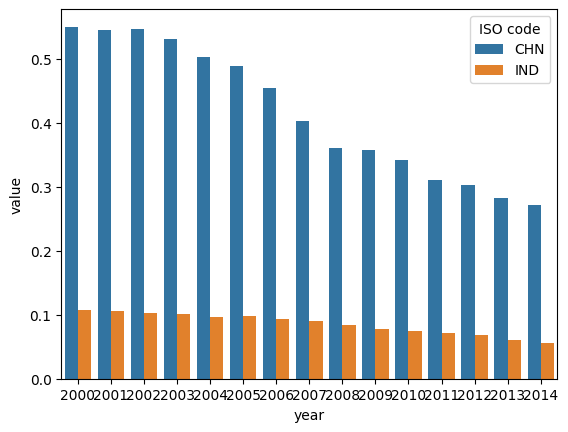

In [20]:
data_filter = PPP_exchage_filtered.loc[(PPP_exchage_filtered['ISO code'].isin(['IND','CHN']))]
sns.barplot(data=data_filter, x='year', y='value', hue='ISO code')

In [21]:
SEA.head()

,country,variable,code,year,value
0,AUS,CAP,A01,2000,5671.916100
1,AUS,CAP,A02,2000,339.327191
2,AUS,CAP,A03,2000,506.239201
3,AUS,CAP,B,2000,16451.361852
4,AUS,CAP,C10-C12,2000,3728.097564


In [22]:
%%time

ind_ppps = []
for (country,year),dfx in tqdm(SEA.groupby(['country','year']), unit=' country'):
    X_ppp = PPP_exchage_filtered.loc[(PPP_exchage_filtered['year']==str(year)) & (PPP_exchage_filtered['ISO code']==country)]['value'].values[0]
    dfx['tot_ind_ppp'] = dfx['value']*X_ppp

    ind_ppps.append(dfx)

tot_ind_ppp_df = pd.concat(ind_ppps).reset_index()
tot_ind_ppp_df.head()

100%|██████████| 645/645 [00:01<00:00, 541.77 country/s]


CPU times: user 2.59 s, sys: 120 ms, total: 2.71 s
Wall time: 2.78 s


,index,country,variable,code,year,value,tot_ind_ppp
0,0,AUS,CAP,A01,2000,5671.916100,5989.825897
1,1,AUS,CAP,A02,2000,339.327191,358.346414
2,2,AUS,CAP,A03,2000,506.239201,534.613810
3,3,AUS,CAP,B,2000,16451.361852,17373.457492
4,4,AUS,CAP,C10-C12,2000,3728.097564,3937.056709


<Axes: xlabel='year', ylabel='tot_ind_ppp'>

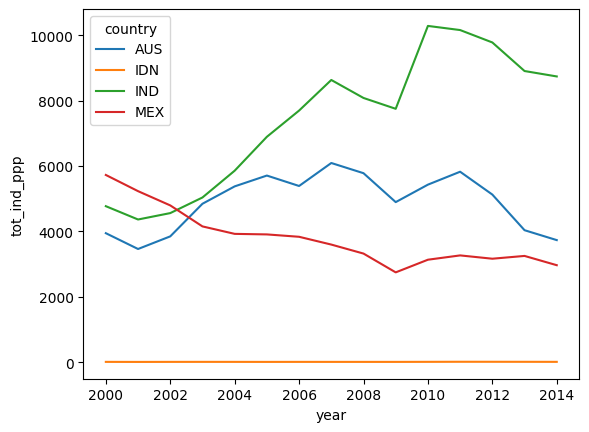

In [23]:
data_filter = tot_ind_ppp_df.loc[(tot_ind_ppp_df['country'].isin(['IND','AUS', 'IDN', "MEX"])) & (tot_ind_ppp_df['code']=='C13-C15') & (tot_ind_ppp_df['variable']=='GO')]
sns.lineplot(data=data_filter, x='year', y='tot_ind_ppp', hue='country')

In [24]:
tot_ind_ppp_df_GO = tot_ind_ppp_df[tot_ind_ppp_df['variable']=='GO']
tot_ind_ppp_df_GO = tot_ind_ppp_df_GO.groupby(['code','year']).sum().reset_index().drop(['country','value','variable','index'], axis=1)
tot_ind_ppp_df_GO.head()

,code,year,tot_ind_ppp
0,A01,2000,1.253676e+06
1,A01,2001,1.118330e+06
2,A01,2002,1.084637e+06
3,A01,2003,1.198307e+06
4,A01,2004,1.346732e+06


In [76]:
SEA_USD_x = pd.melt(SEA_USD, id_vars=['country', 'code', 'variable'], value_vars=year_range)
SEA_USD_x = SEA_USD_x.loc[SEA_USD_x['variable']=="GO"]
SEA_USD_x = SEA_USD_x.groupby(['code','year']).sum().reset_index().drop(['country','variable'], axis=1)

SEA_USD_x['SEA_by_PPP'] = SEA_USD_x['value']/tot_ind_ppp_df_GO['tot_ind_ppp']
SEA_USD_x.drop('value', axis=1, inplace=True)
print(SEA_USD_x.shape)
SEA_USD_x.head(5)

(840, 3)


,code,year,SEA_by_PPP
0,A01,2000,1.020325
1,A01,2001,1.143019
2,A01,2002,1.194055
3,A01,2003,1.228810
4,A01,2004,1.268222


In [71]:
PPP_exchage_filtered.head()

,ISO code,Country,year,value
8,AUS,Australia,2000,1.056050
9,AUT,Austria,2000,1.447184
12,BEL,Belgium,2000,1.421313
16,BGR,Bulgaria,2000,2.679952
24,BRA,Brazil,2000,1.352885


In [102]:
%%time
ind_ex_rates = []
for (country,year),dfx in tqdm(PPP_exchage_filtered.groupby(['Country','year']), unit=' country'):
    ppp_ex = dfx['value'].values[0]
    sea_by_ppp_x = SEA_USD_x[SEA_USD_x['year']==int(year)].copy()
    sea_by_ppp_x['country'] = dfx['ISO code'].values[0]
    sea_by_ppp_x['ind_ppp_ex'] = sea_by_ppp_x['SEA_by_PPP']*ppp_ex

    ind_ex_rates.append(sea_by_ppp_x)

ind_ex_rate = pd.concat(ind_ex_rates).reset_index(drop=True)
ind_ex_rate.head()

100%|██████████| 645/645 [00:02<00:00, 250.18 country/s]


CPU times: user 1.78 s, sys: 16.6 ms, total: 1.79 s
Wall time: 2.86 s


,code,year,SEA_by_PPP,country,ind_ppp_ex
0,A01,2000,1.020325,AUS,1.077514
1,A02,2000,1.169338,AUS,1.234879
2,A03,2000,1.601796,AUS,1.691577
3,B,2000,1.038940,AUS,1.097172
4,C10-C12,2000,0.958641,AUS,1.012372


### Country Industry PPP

In [110]:
SEA_GO = SEA[SEA['variable']=="GO"].drop('variable',axis=1)
country_ind_ppp = pd.merge(
    left=SEA_GO,
    right=ind_ex_rate,
    left_on = SEA_GO['country']+SEA_GO['code']+SEA_GO['year'].astype(str),
    right_on =ind_ex_rate['country']+ind_ex_rate['code']+ind_ex_rate['year'].astype(str),
    suffixes=('', '_y'),
    how='inner'
)


country_ind_ppp['country_ind_ppp'] = country_ind_ppp['value']*country_ind_ppp['ind_ppp_ex']

country_ind_ppp = country_ind_ppp.drop(['key_0', 'code_y','year_y','SEA_by_PPP', 'country_y'], axis=1)
country_ind_ppp.dropna(inplace=True)
country_ind_ppp.sample(5)

,country,code,year,value,ind_ppp_ex,country_ind_ppp
32932,MEX,C10-C12,2013,161206.950222,0.209539,33779.223338
7920,ESP,E36,2003,5654.868800,1.899668,10742.371602
30844,PRT,M69_M70,2012,7621.819040,1.829532,13944.360955
10884,IRL,C30,2004,547.440390,1.509647,826.441516
13988,PRT,M69_M70,2005,6407.115000,1.477239,9464.841308


### World Industry Value

In [138]:
GO_industry_total = SEA_GO.groupby(['code','year']).sum().reset_index().drop(columns=['country'],axis=1)
GO_industry_total = GO_industry_total.rename(columns = {'value':'GO'})

SEA_HEMPE = SEA[SEA['variable']=="H_EMPE"].copy().drop(columns=['country', 'variable'],axis=1)
HEMPE_industry_total = SEA_HEMPE.groupby(['code','year']).sum().reset_index()
HEMPE_industry_total = HEMPE_industry_total.rename(columns = {'value':'H_EMPE'})

HEMPE_GO_ind_total = HEMPE_industry_total.set_index(['code','year']).join(GO_industry_total.set_index(['code','year'])).reset_index()
HEMPE_GO_ind_total.sample(3)

,code,year,H_EMPE,GO
108,C17,2003,2595.210452,5.233498e+05
806,R_S,2011,30872.397905,2.653376e+06
459,H49,2009,18272.476676,2.392736e+06


In [141]:
%%time
world_industry_values = []
for country,dfx in tqdm(country_ind_ppp.groupby(['country']), unit=' country'):
    world_industry_value = pd.merge(
        left=dfx,
        right=HEMPE_GO_ind_total,
        left_on = dfx['code']+dfx['year'].astype(str),
        right_on =HEMPE_GO_ind_total['code']+HEMPE_GO_ind_total['year'].astype(str),
        suffixes=('', '_y'),
        how='inner'
    )

    world_industry_value = world_industry_value.drop(['key_0', 'code_y','year_y'], axis=1)

    world_industry_values.append(world_industry_value)

world_industry_values = pd.concat(world_industry_values).reset_index(drop=True)
world_industry_values.head()

100%|██████████| 43/43 [00:00<00:00, 73.40 country/s]


CPU times: user 363 ms, sys: 5.73 ms, total: 369 ms
Wall time: 633 ms


,country,code,year,value,ind_ppp_ex,country_ind_ppp,H_EMPE,GO
0,AUS,A01,2000,28947.959607,1.077514,31191.820626,24210.180509,1.279156e+06
1,AUS,A02,2000,1506.081860,1.234879,1859.828919,2538.245812,1.216315e+05
2,AUS,A03,2000,1512.383426,1.691577,2558.312335,999.393418,9.602048e+04
3,AUS,B,2000,34012.527846,1.097172,37317.593365,3184.563497,7.389781e+05
4,AUS,C10-C12,2000,34168.387512,1.012372,34591.134059,15003.757675,2.206682e+06


In [151]:
world_industry_values.to_excel('world_industry_values.xlsx')

## Homogeneous Labour



In [160]:
# ## Homogeneous Labour with Adjusted Dollar
# ppp1_GO = ppp1[ppp1['variable']=='GO'].melt(id_vars = ['code', 'variable'], value_vars=year_range)
# ppp1_GO.sample(3)

# ## Homogeneous Labour with Standard Dollar
# ppp2_GO = ppp2[ppp2['variable']=='GO'].melt(id_vars = ['code', 'variable'], value_vars=year_range)
# ppp2_GO.sample(3)

In [161]:
# hom_labour = country_industry_ppp_rate_df[country_industry_ppp_rate_df['variable']=='GO'].copy()
# hom_labour['homogeneous'] = hom_labour['country_industry_ppp_rate'].values*SEA[SEA['variable']=='GO']['value'].values
# hom_labour.head()

In [162]:
# %%time

# hom_labours = []
# for country,dfx in tqdm(hom_labour.groupby('country'), unit=' country'):

#     x_merge = pd.merge(left = dfx,
#         right=ppp2_GO,
#         left_on=dfx['year'].astype(str)+dfx['code'],
#         right_on=ppp2_GO['year'].astype(str)+ppp2_GO['code'],
#         how='inner',
#         suffixes=('', '_y')
#     )
#     x_merge['h2'] = x_merge['homogeneous']/x_merge['value']
#     x_merge = x_merge.drop(['key_0','code_y', 'variable_y', 'year_y', 'country_industry_ppp_rate', 'value'], axis=1)

#     x_merge = pd.merge(left = x_merge,
#         right=ppp1_GO,
#         left_on=dfx['year'].astype(str)+dfx['code'],
#         right_on=ppp1_GO['year'].astype(str)+ppp1_GO['code'],
#         how='inner',
#         suffixes=('', '_y')
#     )
#     x_merge['h3'] = x_merge['homogeneous']/x_merge['value']
#     x_merge = x_merge.drop(['key_0','code_y', 'variable_y', 'year_y', 'homogeneous', 'value'], axis=1)

#     hom_labours.append(x_merge)

# hom_labour2 = pd.concat(hom_labours)
# hom_labour2.head()

In [163]:
# hom_labour2.shape

In [164]:
# data_filter = hom_labour2[hom_labour2['country']=='USA']
# sns.lineplot(data=data_filter, x='year', y='h2')
# sns.lineplot(data=data_filter, x='year', y='h3')

## World Input Output Analysis

In [165]:
# hours = SEA[SEA['variable']=='H_EMPE'].copy().drop(['country','variable'],axis=1)
# hours = hours.groupby(['year','code']).sum().reset_index()
# hours.sample(4)

In [166]:
# %%time

# hom_labours = []
# for country,dfx in tqdm(hom_labour2.groupby('country'), unit=' country'):

#     x_merge = pd.merge(left = dfx,
#         right=hours,
#         left_on=dfx['year'].astype(str)+dfx['code'],
#         right_on=hours['year'].astype(str)+hours['code'],
#         how='inner',
#         suffixes=('', '_y')
#     )

#     x_merge['hom_labour'] = x_merge['h2']*x_merge['value']
#     x_merge = x_merge.drop(['key_0','code_y', 'year_y', 'value','h2','h3'], axis=1)

#     hom_labours.append(x_merge)

# hom_labour3 = pd.concat(hom_labours)
# hom_labour3.sample(5)

In [167]:
# data_filter = hom_labour3.loc[(hom_labour3['country'].isin(['IND','CHN','AUS', 'IDN', "MEX"])) & (hom_labour3['code']=='C13-C15')]
# sns.lineplot(data=data_filter, x='year', y='hom_labour', hue='country')

## Input Output Tables

In [168]:
# %%time
# df = pd.read_excel('WIOT2000_Nov16_ROW.xlsb', engine='pyxlsb')

In [169]:
# df.head(10)

In [170]:
# industries = df.iloc[5:, :3].reset_index(drop=True).copy()
# industries.columns = ['code', 'industry', 'country']
# print('Total number of industries',industries.shape[0])
# industries

In [171]:
# value = df.iloc[5:, 4:industries.shape[0]+4].copy()
# value.columns = industries['code']
# value['industry'] = industries['code']
# value['country'] = industries['country']
# value.sample(5)

In [172]:
# isProductive = ['K64', 'K65', 'K66', 'L68', 'M69_M70', 'N', 'O84', 'T', 'U']

# value[value['industry'].isin(isProductive)].groupby('country').sum().iloc[:,:-1].sum(axis=1)